HARSIMAR MANGAT
ASSIGNMENT 7.2: CREATE OPTIMAL HOTEL RECCOMENDATIONS

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime 


we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.

For the assignment, I utilized a random forest classifier, predominately because we when reviewed the correlation matrix we saw very little correlation with any variable with hotel clusters. To that end, i presumed that regression may not be very successful. 

We ran two iterations of the random forest model, but in each case we did something different. The first run, we had the # of estimators at 10 and we exluded the check in and out dates, and otherwise used all our other columns.

The 2nd iteration of the random forest, we performed some feature engineering. We extracted the month and day from the check in and check out columns, and used them in our model. In addition, we increased our # of estimators to 30.

In [2]:
dest=pd.read_csv("destinations.csv")
#Due to the original data set having so many rows, we are only extracting the first million.
train = pd.read_csv('train.csv', nrows=1000000)


In [3]:
#Data Preprocessing
train.columns

Index(['date_time', 'site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

C:\Users\hsman\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hotel_cluster', ylabel='Density'>

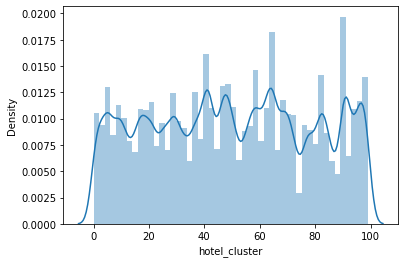

In [4]:
sns.distplot(train['hotel_cluster'])
#Our goal is to predict hotel clusters. A quick histogram shows our snapshot of hotel_clusters - no clear distribution.

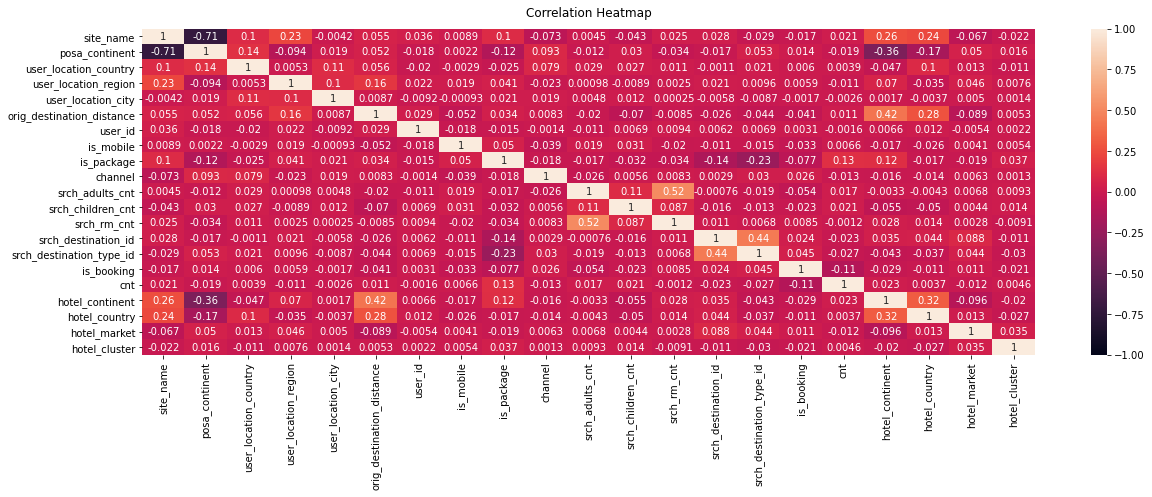

In [5]:
plt.figure(figsize=(20, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

When we look at the look at the correlation heat map, we see quite clearly that there is very little
correlation with any column/variable against hotel_cluster. This makes a regression model not very effective

In [6]:
most_common_clusters = list(train.hotel_cluster.value_counts().head().index)
print(most_common_clusters)

[91, 41, 64, 48, 5]


In [7]:
predictions = [most_common_clusters for i in range(train.shape[0])]
#We identify the 5 most common clusters and use them as the first list of predictions

In [9]:
import ml_metrics as metrics
target = [[l] for l in train['hotel_cluster']]
metrics.mapk(target, predictions, k=5)
#Mean Average Precision can be defined as the average precision values with 
#respect to the number of predictions needed.
#Like the professor had alluded too, Unsurprisingly, the MAP is not good at all.

0.05343841666666665

In [10]:
#We also have available the dataset destinations. The only column that we can clearly identify is the 
#srch_destination_id column, and all the other columns we can't gleam anything from, but we can still use 
#them. First we need to compress the # of columns down, through a process called PCA (which will reduce the size of our data while preserving the variance between rows.)
#PCA = Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
dest_small = pca.fit_transform(dest[["d{0}".format(i + 1) for i in range(149)]])
dest_small = pd.DataFrame(dest_small)
dest_small["srch_destination_id"] = dest["srch_destination_id"]

In [11]:
#Merge the Destination dataset with the train dataset
ret=pd.DataFrame()
ret = train.join(dest_small, on="srch_destination_id", how='left', rsuffix="dest")

In [12]:
ret.corr()['hotel_cluster']
#When we look at the correlation, again, now with the new columns from destination.csv - we still dont see
#any relevant or strong correlation

site_name                   -0.021735
posa_continent               0.015654
user_location_country       -0.010500
user_location_region         0.007605
user_location_city           0.001436
orig_destination_distance    0.005310
user_id                      0.002235
is_mobile                    0.005415
is_package                   0.036933
channel                      0.001340
srch_adults_cnt              0.009280
srch_children_cnt            0.013596
srch_rm_cnt                 -0.009112
srch_destination_id         -0.011487
srch_destination_type_id    -0.030390
is_booking                  -0.021479
cnt                          0.004563
hotel_continent             -0.019543
hotel_country               -0.026660
hotel_market                 0.034884
hotel_cluster                1.000000
0                           -0.033762
1                           -0.001025
2                            0.007414
srch_destination_iddest     -0.011503
Name: hotel_cluster, dtype: float64

In [14]:
ret=ret.drop(columns=['date_time'])
ret=ret.dropna()

MODEL 1

In [15]:

#Lets assume all our columns will be used as predictors. We take out check in and check out since they have different data types (date-string)
predictors = [c for c in ret.columns if c not in ["hotel_cluster",'srch_ci','srch_co']]

In [16]:
ret.columns

Index([                'site_name',            'posa_continent',
           'user_location_country',      'user_location_region',
              'user_location_city', 'orig_destination_distance',
                         'user_id',                 'is_mobile',
                      'is_package',                   'channel',
                         'srch_ci',                   'srch_co',
                 'srch_adults_cnt',         'srch_children_cnt',
                     'srch_rm_cnt',       'srch_destination_id',
        'srch_destination_type_id',                'is_booking',
                             'cnt',           'hotel_continent',
                   'hotel_country',              'hotel_market',
                   'hotel_cluster',                           0,
                                 1,                           2,
         'srch_destination_iddest'],
      dtype='object')

In [17]:
x=ret[predictors]
y=ret['hotel_cluster']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [19]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [20]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.32210165316458383


In [70]:
#We're using a random forest to predict hotel clusters, and when we estimated the accuracy of our predictions 
#we scored .322, which is not very good.

MODEL 2

In [33]:

#Now we perform some feature engineering, and we use the search check in and out dates....
#but break out the date into month and days so we can ingest into our model.

str

In [44]:
#ret['co']=datetime.datetime.strptime(ret['srch_co'], "%Y-%m-%d")
ret['co']=pd.to_datetime(ret['srch_co'], format='%Y-%m-%d')
ret['ci']=pd.to_datetime(ret['srch_ci'], format='%Y-%m-%d')

In [60]:
ret['co_m'] = (ret['co'].dt.strftime('%m')).astype(int)
ret['co_d'] = (ret['co'].dt.strftime('%d')).astype(int)
ret['ci_m'] = (ret['ci'].dt.strftime('%m')).astype(int)
ret['ci_d'] = (ret['ci'].dt.strftime('%d')).astype(int)


In [61]:
ret.corr()['hotel_cluster']
#We run another correlation, this time to observe any correlation between the search check in and out 
#and hotel clusters, and we still see nothing - therefore regression continue to NOT be helpful.

site_name                   -0.026512
posa_continent               0.013766
user_location_country       -0.018253
user_location_region         0.007359
user_location_city          -0.000078
orig_destination_distance    0.005407
user_id                      0.004569
is_mobile                    0.004233
is_package                   0.045480
channel                     -0.001156
srch_adults_cnt              0.006530
srch_children_cnt            0.011473
srch_rm_cnt                 -0.009579
srch_destination_id         -0.015077
srch_destination_type_id    -0.034905
is_booking                  -0.024166
cnt                          0.004375
hotel_continent             -0.003871
hotel_country               -0.026251
hotel_market                 0.022893
hotel_cluster                1.000000
0                           -0.041918
1                            0.001414
2                            0.009910
srch_destination_iddest     -0.015187
co_m                        -0.001230
co_d        

In [63]:

predictors = [c for c in ret.columns if c not in ["hotel_cluster",'srch_ci','srch_co','co','ci']]

In [65]:
x=ret[predictors]
y=ret['hotel_cluster']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [68]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [69]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#Even with adding additional features, even as specific as lumping in check in and out days and months
#we still dont get any closer in increasing our accuracy.


Accuracy: 0.32510113290084197
